In [28]:
import numpy as np
from tqdm import tqdm
from numba import jit, cuda


@jit(nopython=True)

def omp(D, X, k, epsilon):
    # OMP Solve the P0 problem via OMP
    #
    # Solves the following problem:
    #   min_x ||X - D.A||_2^2 s.t. ||A||_0 <= k
    #
    # The solution is returned in the vector A

    # CCH 20211221 convert INT X to FLOAT X for correct processing in JIT
    X_float = X + 1E-5

    A = np.zeros((np.shape(X)[1], D.shape[0]))
    #print(A)

    sup = np.zeros(D.shape[0])
    print(sup)
    X_solved = np.zeros(X.shape)
    print(X_solved)

    max_steps = 0
    sum_steps = 0

    # CCH 20210713 traverse all patches
    for p in range(np.shape(X)[1]):

        # for p in range(1):
        # print('numpy in OMP now: ', p)
        A_calc = np.zeros(D.shape[0])
        norm_residu = np.linalg.norm(X_float[:,p])
        if norm_residu == 0:
            norm_residu = 1

        # CCH Initialize residual (met gehele signaal)
        residu_ca = np.ascontiguousarray(X_float[:,p])
        X_mat = residu_ca / norm_residu

        step = 0

        #print(np.linalg.norm(residu), epsilon)

        A0 = np.zeros((20, D.shape[0]))

        while ((np.linalg.norm( residu_ca ) > epsilon) and (step < k)):

            # print("p, STEP, norm residu, epsilon", p , step, np.linalg.norm(residu), epsilon)
            # printSparseVector(residu)
            v = np.dot(D.T, residu_ca)

            # print(v.shape)
            # CCH get max inner product column = best fitting atom from D
            A_idx = np.argmax(np.abs(v))
            # print( 'A idx:', A_idx)
            sup[step] = A_idx

            A0[step] = D[:, A_idx]

            # c = np.linalg.lstsq(A0[:step+1].T, X_mat.T, rcond=None)
            c = np.linalg.lstsq(A0[:step + 1].T, X_mat.T)

            # CCH update A
            for i in range(0, step+1):
                #A_calc[np.int(sup[i].item())] = c[0][i].item()
                A_calc[int(sup[i].item())] = c[0][i].item()


            # CCH 20200504 residu berekenen
            residu_ca = np.ascontiguousarray(np.asarray(np.subtract(X_float[:, p] / norm_residu, np.dot(D, A_calc))))

            step = step + 1

        if step == k:
            max_steps += 1

        A[p,:] = A_calc

        X_solved[:,p] = np.dot(D, A[p,:].T)
        X_solved[:,p] = X_solved[:,p] * norm_residu

    # print('OMP max step quit % {:.2f}'.format(100 * max_steps / np.shape(X)[1]))

    return X_solved , A.T

def printSparseVector(x):
    print("sparse vector contents")
    for i in range(0,len(x)):
        if x[i] != 0:
            print("[", i,"]=", x[i])

In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from importlib import reload

from build_dct_unitary_dictionary import build_dct_unitary_dictionary

from im2col import im2col
from col2im import col2im
from compute_psnr import compute_psnr

#CCH 20200520 widthen display output
np.set_printoptions(formatter={'float': lambda x: " {0:7.3f}".format(x)})


In [13]:
def showResult(estimate_image, orig_image):
    cmap_range = 5.0

    fig = plt.figure(1, figsize=[15, 10])
    plt.subplot(1, 3, 1)
    plt.imshow(im, 'gray', vmin=0, vmax=255)
    plt.title('Original image')

    plt.subplot(1, 3, 2)
    plt.imshow(estimate_image, 'gray', vmin=0, vmax=255)
    plt.title('Recovered image')

    psnr = compute_psnr(estimate_image, orig_image)
    delta_ref = orig_image - estimate_image

    plt.subplot(1, 3, 3)
    plt.title('Delta G.T. (PSNR = {:.2f})'.format(psnr))
    plt.imshow(delta_ref, 'coolwarm', vmin=-cmap_range, vmax=cmap_range)

    plt.show()

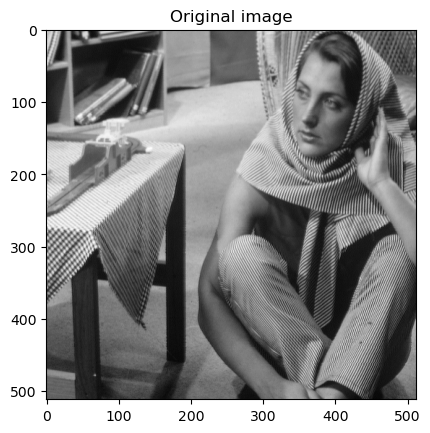

In [14]:
# Read an image
im = np.array(Image.open(r"C:\Users\gyard\OneDrive\Desktop\sparsedemo2\SparseDemo\barbara.png"))
# im = np.array(Image.open('misc\\brain4.jpg'))

# Show the image
plt.figure(0)
plt.imshow(im,'gray') 
plt.title('Original image')
plt.show()

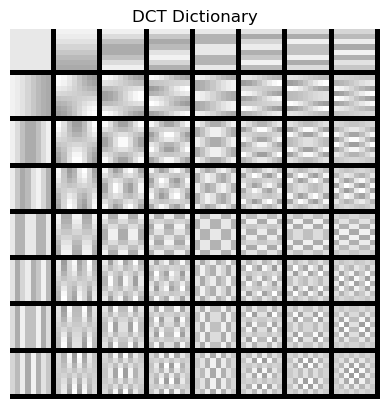

In [20]:
import show_dictionary as showdict
reload(showdict)

# Patch dimensions [height, width]
dim = 8
patch_size = [dim, dim]

D_DCT = build_dct_unitary_dictionary(patch_size)
showdict.showDictionary(D_DCT, 'DCT Dictionary')

In [29]:
#import omp as omplib
#reload(omplib)

# Create the patches from the original image, fully overlapping => stepsize =1
patches = im2col(im, dim, stepsize=1)

# the patches are flattened alongside the y axis (size = dim*dim)
print(patches.shape)

# CCH 20230804 maximum number of atoms per patch
k = 6

# CCH 20230804 maximum deviation per patch
epsilon = 0.02

est_patches, est_coeffs = omp(D_DCT, patches, k, epsilon)

(64, 255025)
[   0.000    0.000    0.000    0.000    0.000    0.000    0.000    0.000
    0.000    0.000    0.000    0.000    0.000    0.000    0.000    0.000
    0.000    0.000    0.000    0.000    0.000    0.000    0.000    0.000
    0.000    0.000    0.000    0.000    0.000    0.000    0.000    0.000
    0.000    0.000    0.000    0.000    0.000    0.000    0.000    0.000
    0.000    0.000    0.000    0.000    0.000    0.000    0.000    0.000
    0.000    0.000    0.000    0.000    0.000    0.000    0.000    0.000
    0.000    0.000    0.000    0.000    0.000    0.000    0.000    0.000]
[[   0.000    0.000    0.000 ...    0.000    0.000    0.000]
 [   0.000    0.000    0.000 ...    0.000    0.000    0.000]
 [   0.000    0.000    0.000 ...    0.000    0.000    0.000]
 ...
 [   0.000    0.000    0.000 ...    0.000    0.000    0.000]
 [   0.000    0.000    0.000 ...    0.000    0.000    0.000]
 [   0.000    0.000    0.000 ...    0.000    0.000    0.000]]
